## Info


## Importing libraries

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Need to know

Série temporal:
- Função que depende do tempo
- Sucessão no tempo

Caracteristicas:
- Tendência
- Sazonalidade
- Erro
- Padrões

## AULA 01 - O PROBLEMA DE TIME SERIES

### Tendência
- Evolução temporal
- Direção

### Sazonalidade
- Oscilação constante
- Entender como funcionam as oscilações da série temporal
- Recorrência das oscilações

### Resíduo
- O que sobra do sinal

***

### Reading data

In [2]:
df_path = 'https://raw.githubusercontent.com/carlosfab/datasets/master/electricity_consumption/Electric_Production.csv'
df = pd.read_csv(df_path)
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


### Handling with date column
Set proper index

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


Date está como texto, precisa converter

In [4]:
df.index = pd.to_datetime(df.DATE, format = '%m-%d-%Y')

In [5]:
df.drop('DATE', inplace=True, axis=1)
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Selecting specific date after normalized

In [6]:
df.loc['1985-05-01']

Value    55.3151
Name: 1985-05-01 00:00:00, dtype: float64

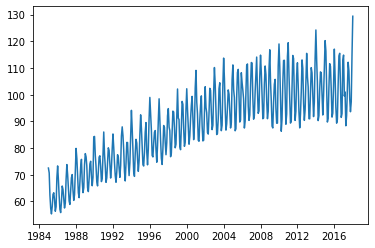

In [7]:
plt.plot(df.index, df.Value)

### Decompor série temporal

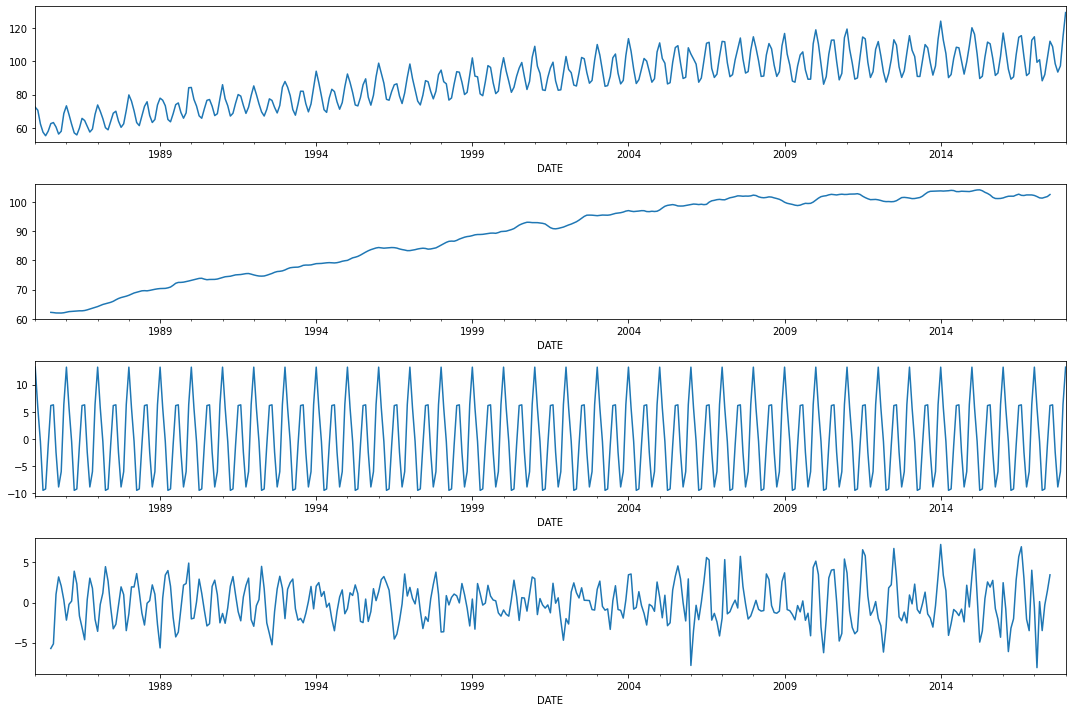

In [8]:
resultados = seasonal_decompose(df)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (15, 10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Série temporal NÃO estacionaria

### Estacionaria ou nâo estacionaria

. Estacionaria
- evolução temporal constante
- médica constante

#### Teste ADF
ADF -> teste para se existe estacionaridade na serie temporal

h0 - hipotese nula (não é estacionária):

h1 - hipótese alternativa (rejeição da hipotenese nula = a série é estacionaria)


p-value = 0.05 (5%) - então rejeitamos H0 com um nível de confiança de 95%

In [9]:
sns.set_style('darkgrid')

In [10]:
x = df.Value.values

In [11]:
result = adfuller(x)

print('Test ADF')
print(f'Teste estatistico: {result[0]}')
print(f'p-value: {result[1]}')

print('Valores críticos')
for key, value in result[4].items():
    print(f'Key\t{key}: {value}')

Test ADF
Teste estatistico: -2.256990350047227
p-value: 0.1862146911658738
Valores críticos
Key	1%: -3.4476305904172904
Key	5%: -2.869155980820355
Key	10%: -2.570827146203181


Conclusão
- Série não estacionaria

Ação
- Transformar a série em estacionaria

### Aplicando log para normalizar a série

Visão atual

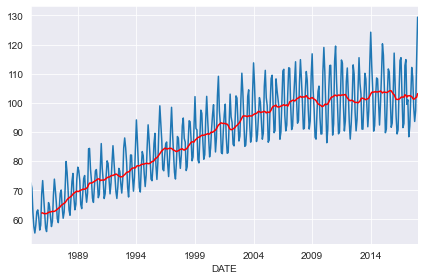

In [12]:
ma = df.rolling(12).mean()

f, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

Visão com log

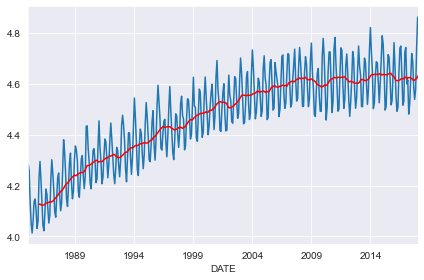

In [13]:
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

A diferença é o eixo Y, transformação de escala em log.

Agora precisamos subtrair a média móvel

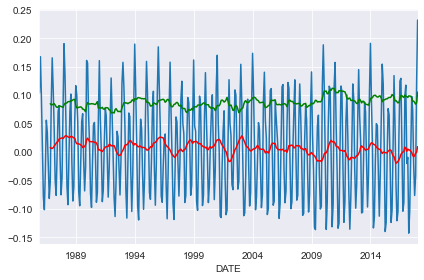

In [14]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

Decompondo a série depois de estacionada:

In [15]:
x_s = df_s.Value.values
result_s = adfuller(x_s)

print('Teste ADF')
print(f'Teste estatistico: {result_s[0]}')
print(f'P-value: {result_s[1]}')
print(f'Valores críticos:')

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatistico: -5.211586185365449
P-value: 8.32563975994576e-06
Valores críticos:
	1%: -3.448147967010838
	5%: -2.8693833397824413
	10%: -2.5709483564645725


p_value = 000000.832..........

p_value é menor, assim sabemos que a série temporal agora é estacionaria.

Teste ADF
Teste estatistico: -7.651129568145194
P-value: 1.7881267354355252e-11
Valores críticos:
	1%: -3.448294490928673
	5%: -2.869447722240253
	10%: -2.570982681065269


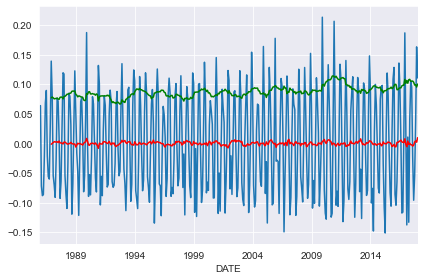

In [16]:
df_diff = df_s.diff(1) #primeira derivada

ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#Testes estatisticos

x_diff = df_diff.Value.dropna().values
result_diff = adfuller(x_diff)

print('Teste ADF')
print(f'Teste estatistico: {result_diff[0]}')
print(f'P-value: {result_diff[1]}')
print(f'Valores críticos:')

for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

- p_value = MUITO PRÓXIMO DE 0
- p_value menor que os testes estatisticos, que é o ideal
- curva bem suavizada

***

## AULA 02 - UTILIZANDO DATAS COMO ÍNDICE

Se tratando de séries temporais, sempre necessário formatar o campo correto como data e configurar como index.

- facilita seleção de dados
- visualização de dados - EDA

In [17]:
df_path = 'https://raw.githubusercontent.com/carlosfab/datasets/master/electricity_consumption/Electric_Production.csv'
df = pd.read_csv(df_path)
df.head(3)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502


In [18]:
df_path = 'https://raw.githubusercontent.com/carlosfab/datasets/master/electricity_consumption/Electric_Production.csv'
df = pd.read_csv(df_path, parse_dates=[0], index_col='DATE')
df.head(3)

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


***

## AULA 03 BIBLIOTECAS FUNDAMENTAIS EM TIME SERIES PROBLEM

Falou sobre Prophet

***

## AULA 04 - ANÁLISE EXPLORATÓRIO DE DADOS (EDA)

Trabalhando com a série "normalizada" (estacionaria)

Diferença crucial entre Regressão x Série temporal:
- interpolação e extrapolação

### Autocorrelação x Autocorreação Parcial

In [26]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

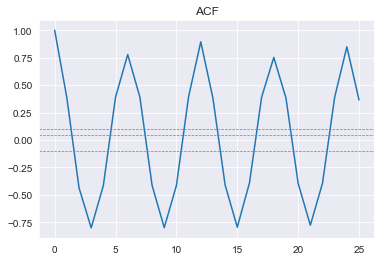

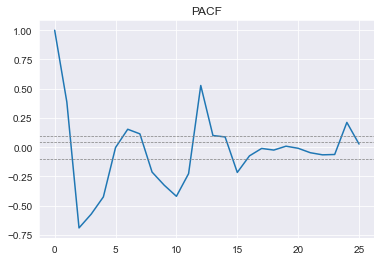

In [27]:
plt.plot(lag_acf)
plt.axhline(y= -1.96 / (np.sqrt((len(df_diff) - 1 ))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0.96 / (np.sqrt((len(df_diff) - 1 ))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96 / (np.sqrt((len(df_diff) - 1 ))), linestyle='--', color='gray', linewidth=0.7)
plt.title('ACF')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y= -1.96 / (np.sqrt((len(df_diff) - 1 ))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0.96 / (np.sqrt((len(df_diff) - 1 ))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96 / (np.sqrt((len(df_diff) - 1 ))), linestyle='--', color='gray', linewidth=0.7)
plt.title('PACF')
plt.show()

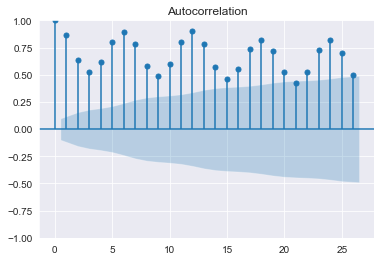

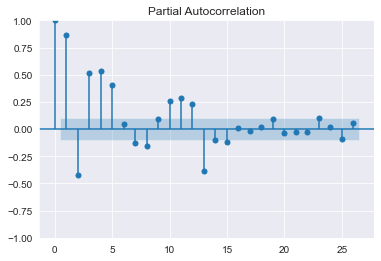

In [31]:
plot_acf(df.Value)
plot_pacf(df.Value)
plt.show()

#### Autocorrelação
- Vai dizer quanto um período está correlacionado com o outro
- direta e indireta

#### Autocorrelação parcial
- apenas a correlação direta

## AULA 05 - MODELANDO E REALIZANDO O FORECASTING

### ARIMA

#### Passos para aplicar modelo ARIMA
1. Visualize os dados da série temporal;
2. Identifique se a data é estacionária;
3. Plot os gráficos de correlação e autocorrelação;
4. Construa o modelo ARIMA com base nos dados.